In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from datetime import datetime
import joblib
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
sns.set_palette("husl")


In [2]:
# Load dataset
df = pd.read_csv('Online.csv')

In [3]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
# Handle missing values
df = df[df['CustomerID'].notna()]
df['Description'] = df['Description'].fillna('No Description')

In [6]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [7]:
# Remove cancellations (ensure InvoiceNo is treated as a string)
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Filter valid transactions using method chaining
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert dates with error handling
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='%d-%m-%Y %H:%M', errors='coerce')

In [8]:
# Calculate total price
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [9]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [11]:
latest_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum',
    'StockCode': 'nunique'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary',
    'StockCode': 'ProductVariety'
})


In [12]:
# Additional features
rfm['AOV'] = rfm['Monetary'] / rfm['Frequency']
rfm['PurchaseInterval'] = rfm['Recency'] / rfm['Frequency']
rfm['TotalItems'] = df.groupby('CustomerID')['Quantity'].sum()

# Log-transform skewed monetary values
pt = PowerTransformer()
rfm['Monetary_log'] = pt.fit_transform(rfm[['Monetary']])

In [13]:
rfm

,Recency,Frequency,Monetary,ProductVariety,AOV,PurchaseInterval,TotalItems,Monetary_log
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,77183.600000,326.000000,74215,3.127756
12347.0,2,7,4310.00,103,615.714286,0.285714,2458,1.376497
12348.0,75,4,1797.24,22,449.310000,18.750000,2341,0.751647
12349.0,19,1,1757.55,73,1757.550000,19.000000,631,0.735059
12350.0,310,1,334.40,17,334.400000,310.000000,197,-0.592221
...,...,...,...,...,...,...,...,...
18280.0,278,1,180.60,10,180.600000,278.000000,45,-1.134978
18281.0,181,1,80.82,7,80.820000,181.000000,54,-1.885613
18282.0,8,2,178.05,12,89.025000,4.000000,103,-1.147838


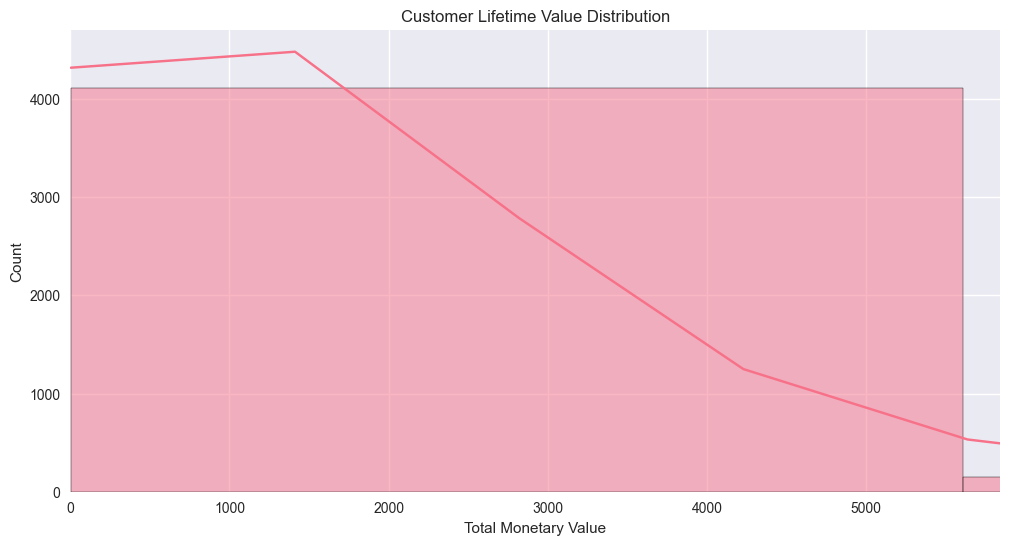

In [14]:
# 1. Monetary Value Distribution
plt.figure(figsize=(12,6))
sns.histplot(rfm['Monetary'], bins=50, kde=True)
plt.title('Customer Lifetime Value Distribution')
plt.xlabel('Total Monetary Value')
plt.xlim(0, rfm['Monetary'].quantile(0.95))
plt.show()

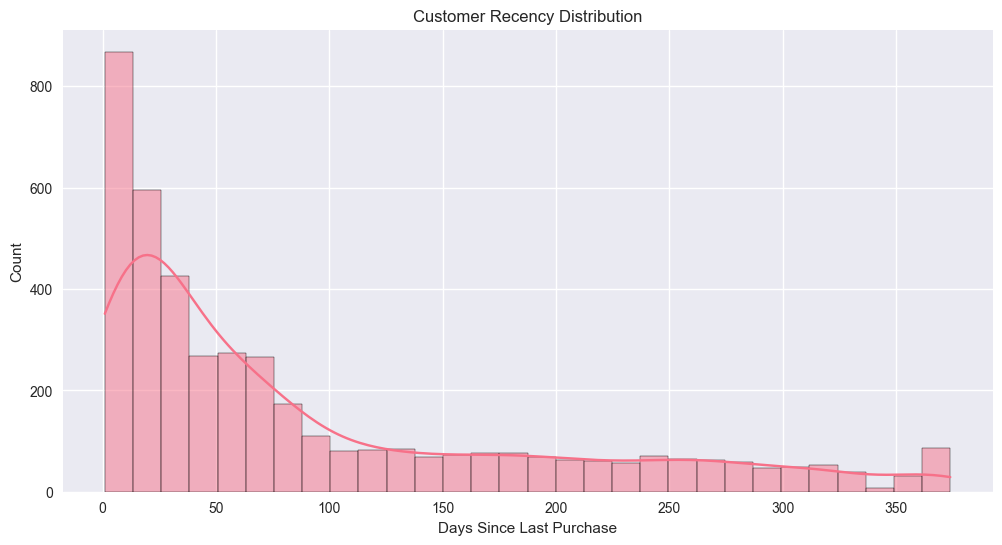

In [15]:
# 2. Recency Distribution
plt.figure(figsize=(12,6))
sns.histplot(rfm['Recency'], bins=30, kde=True)
plt.title('Customer Recency Distribution')
plt.xlabel('Days Since Last Purchase')
plt.show()

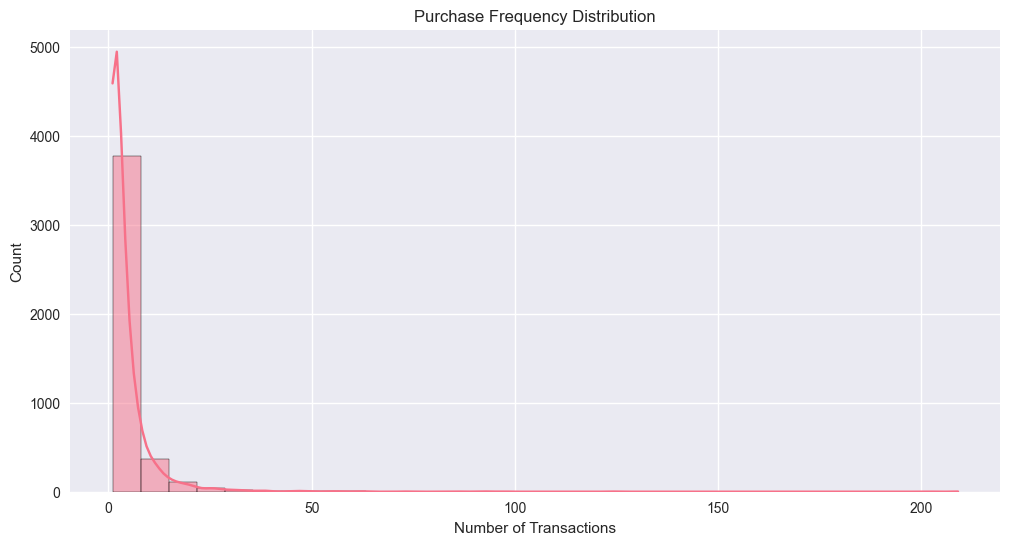

In [16]:
# 3. Frequency Distribution
plt.figure(figsize=(12,6))
sns.histplot(rfm['Frequency'], bins=30, kde=True)
plt.title('Purchase Frequency Distribution')
plt.xlabel('Number of Transactions')
plt.show()

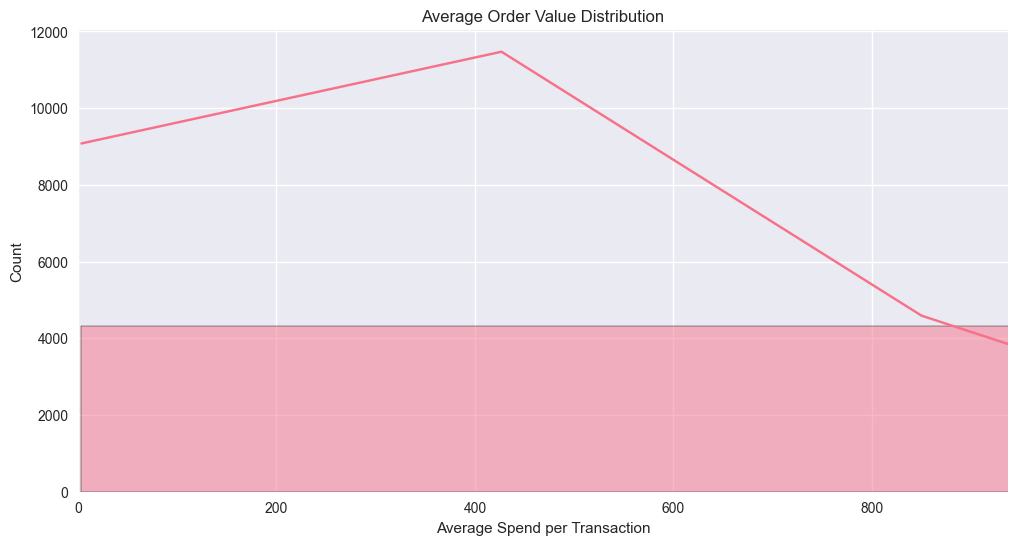

In [17]:
# 4. Average Order Value Distribution
plt.figure(figsize=(12,6))
sns.histplot(rfm['AOV'], bins=30, kde=True)
plt.title('Average Order Value Distribution')
plt.xlabel('Average Spend per Transaction')
plt.xlim(0, rfm['AOV'].quantile(0.95))
plt.show()

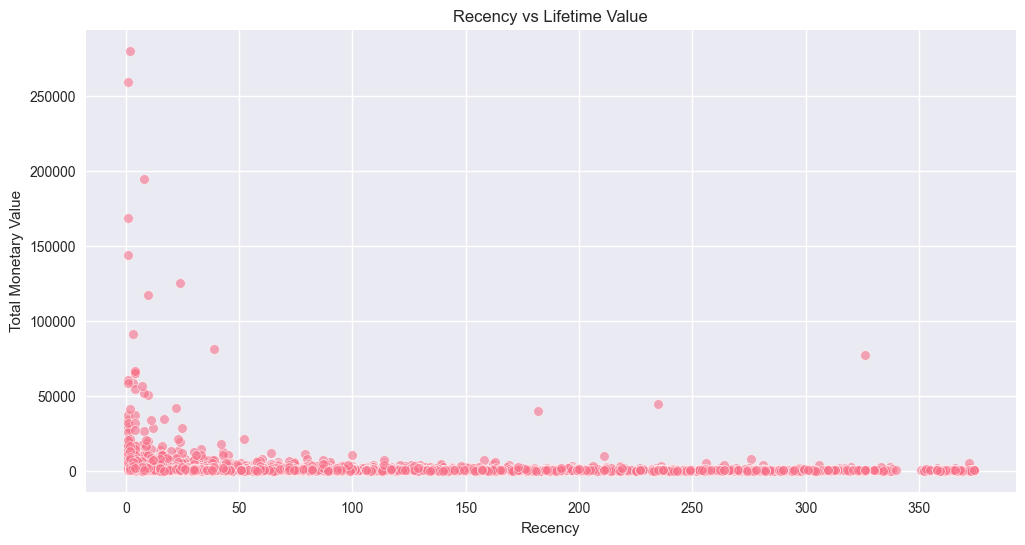

In [18]:
# 5. Monetary vs Recency
plt.figure(figsize=(12,6))
sns.scatterplot(x='Recency', y='Monetary', data=rfm, alpha=0.6)
plt.title('Recency vs Lifetime Value')
plt.ylabel('Total Monetary Value')
plt.show()

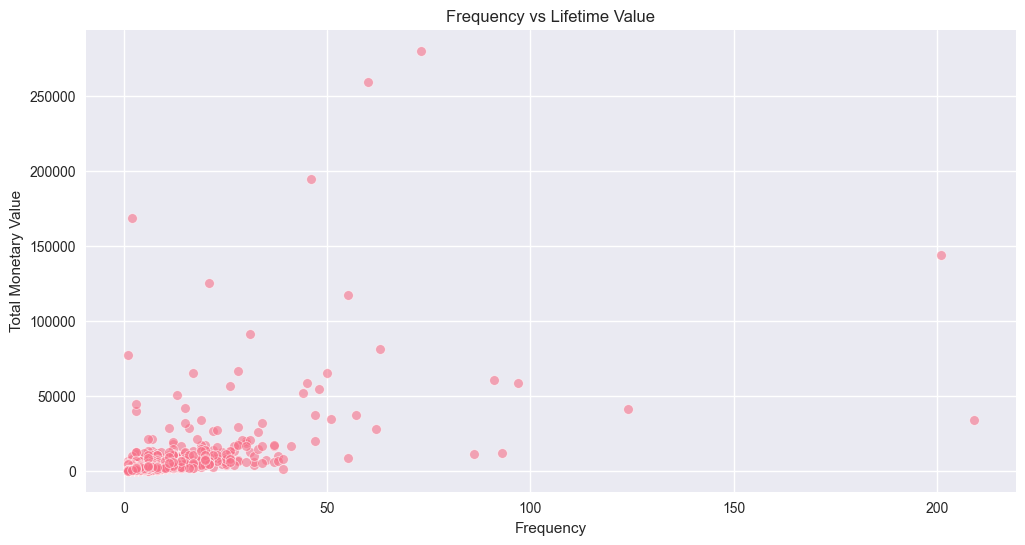

In [19]:
# 6. Monetary vs Frequency
plt.figure(figsize=(12,6))
sns.scatterplot(x='Frequency', y='Monetary', data=rfm, alpha=0.6)
plt.title('Frequency vs Lifetime Value')
plt.ylabel('Total Monetary Value')
plt.show()

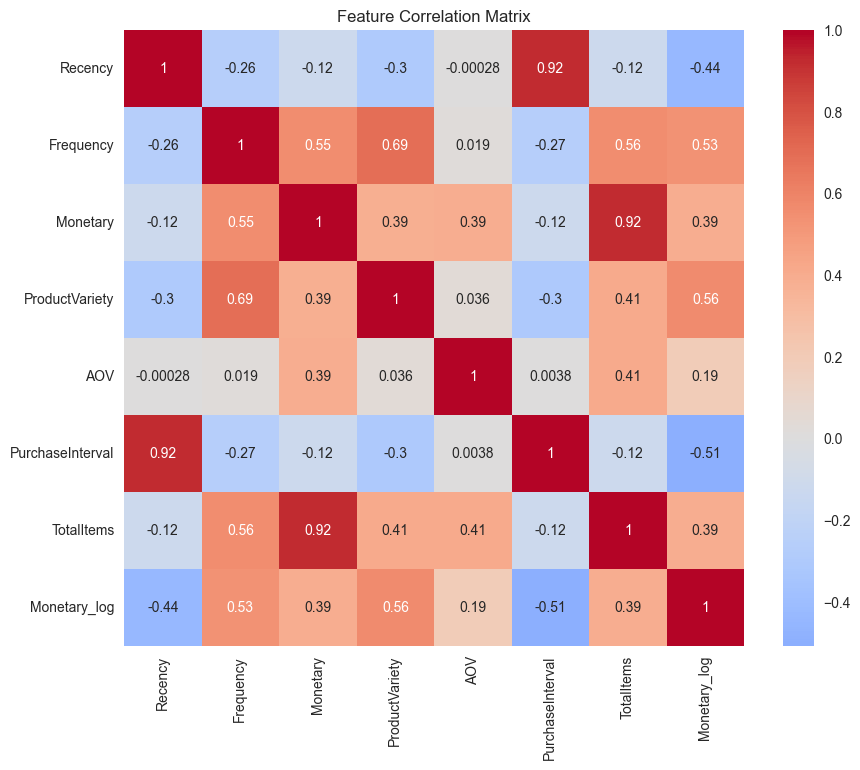

In [20]:
# 7. Correlation Heatmap
plt.figure(figsize=(10,8))
corr = rfm.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

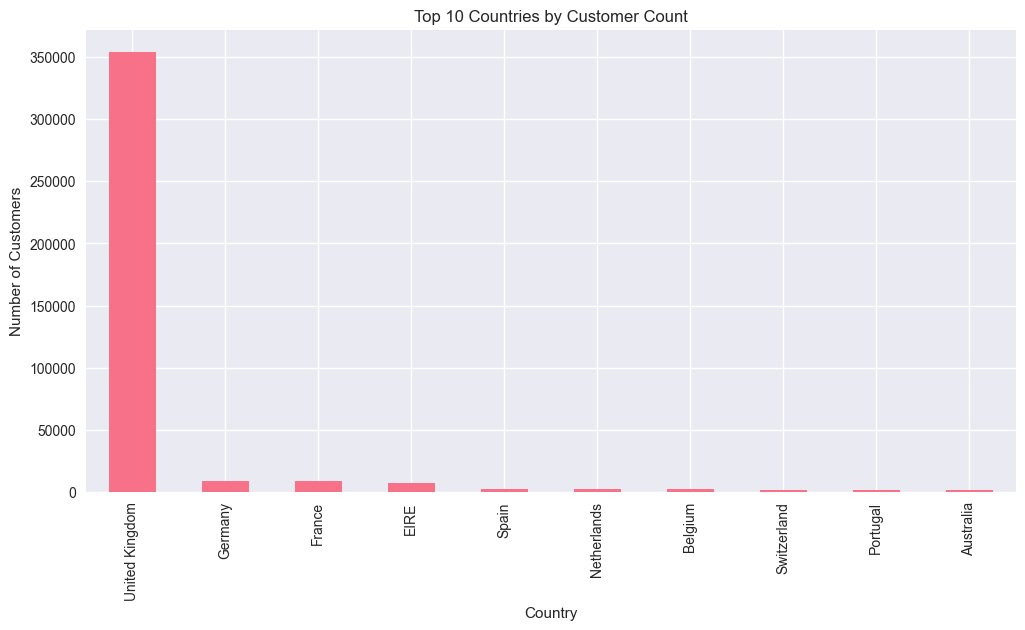

In [21]:
# 8. Country-wise Customer Distribution
plt.figure(figsize=(12,6))
df['Country'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Countries by Customer Count')
plt.xlabel('Country')
plt.ylabel('Number of Customers')
plt.show()

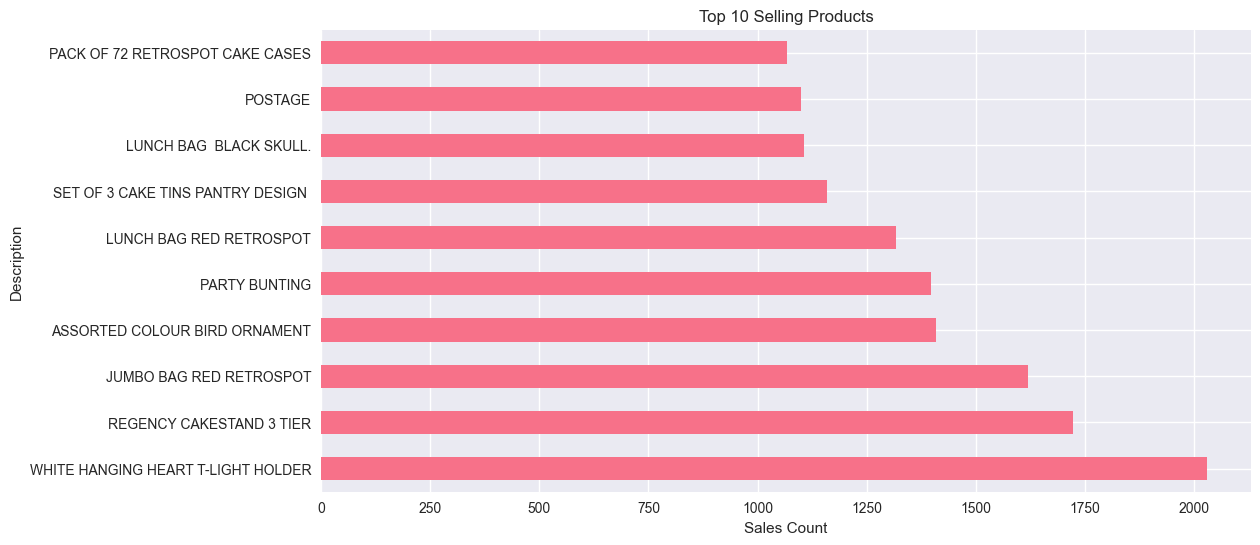

In [22]:
# 9. Top Selling Products
plt.figure(figsize=(12,6))
df['Description'].value_counts().head(10).plot(kind='barh')
plt.title('Top 10 Selling Products')
plt.xlabel('Sales Count')
plt.show()

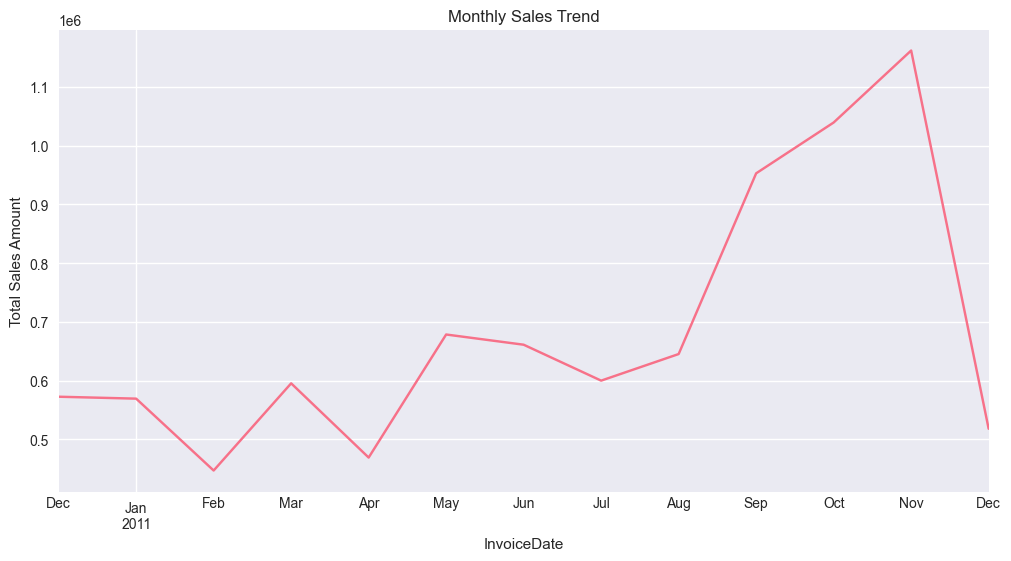

In [23]:
# 10. Monthly Sales Trend
plt.figure(figsize=(12,6))
df.set_index('InvoiceDate')['TotalPrice'].resample('M').sum().plot()
plt.title('Monthly Sales Trend')
plt.ylabel('Total Sales Amount')
plt.show()

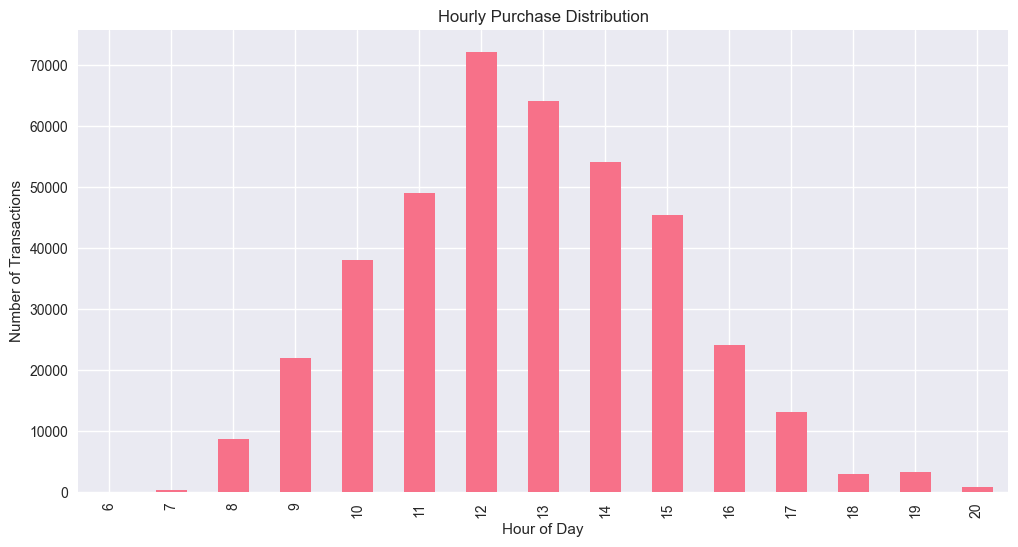

In [24]:
# 11. Hourly Purchase Pattern
plt.figure(figsize=(12,6))
df['InvoiceDate'].dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Hourly Purchase Distribution')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Transactions')
plt.show()

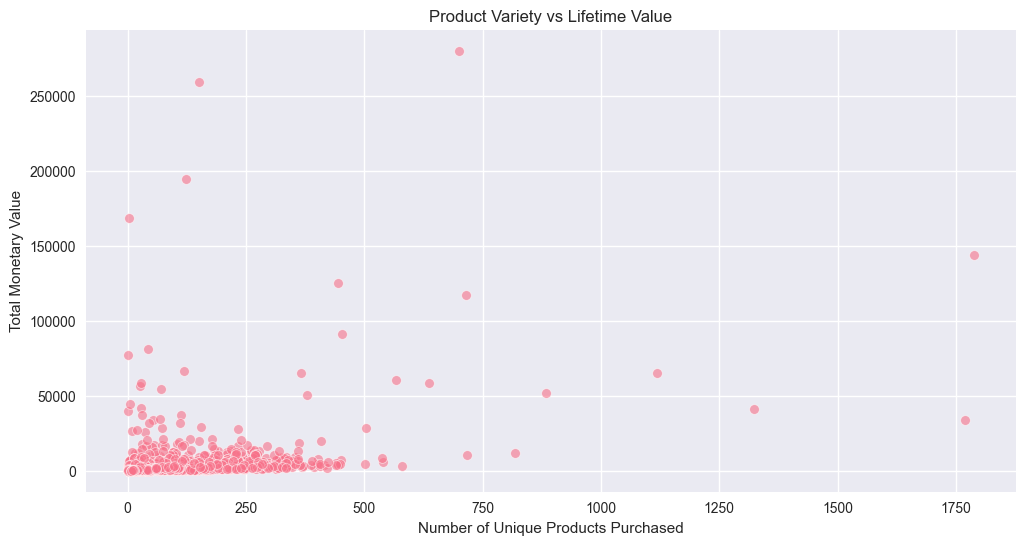

In [25]:
# 12. Product Variety vs LTV
plt.figure(figsize=(12,6))
sns.scatterplot(x='ProductVariety', y='Monetary', data=rfm, alpha=0.6)
plt.title('Product Variety vs Lifetime Value')
plt.xlabel('Number of Unique Products Purchased')
plt.ylabel('Total Monetary Value')
plt.show()

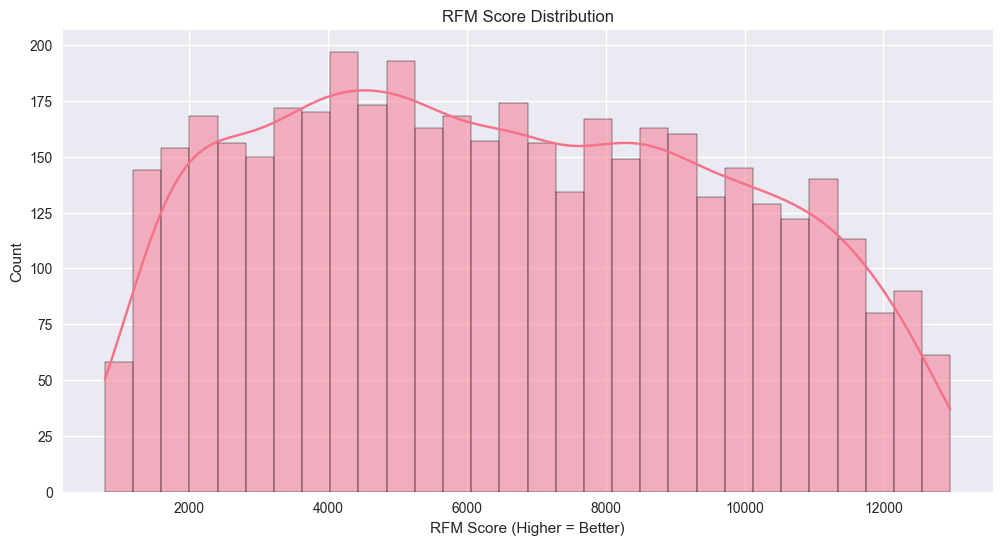

In [26]:
# 13. RFM Score Distribution
rfm['RFM_Score'] = (rfm['Recency'].rank(ascending=False) + 
                    rfm['Frequency'].rank(ascending=True) + 
                    rfm['Monetary'].rank(ascending=True))

plt.figure(figsize=(12,6))
sns.histplot(rfm['RFM_Score'], bins=30, kde=True)
plt.title('RFM Score Distribution')
plt.xlabel('RFM Score (Higher = Better)')
plt.show()


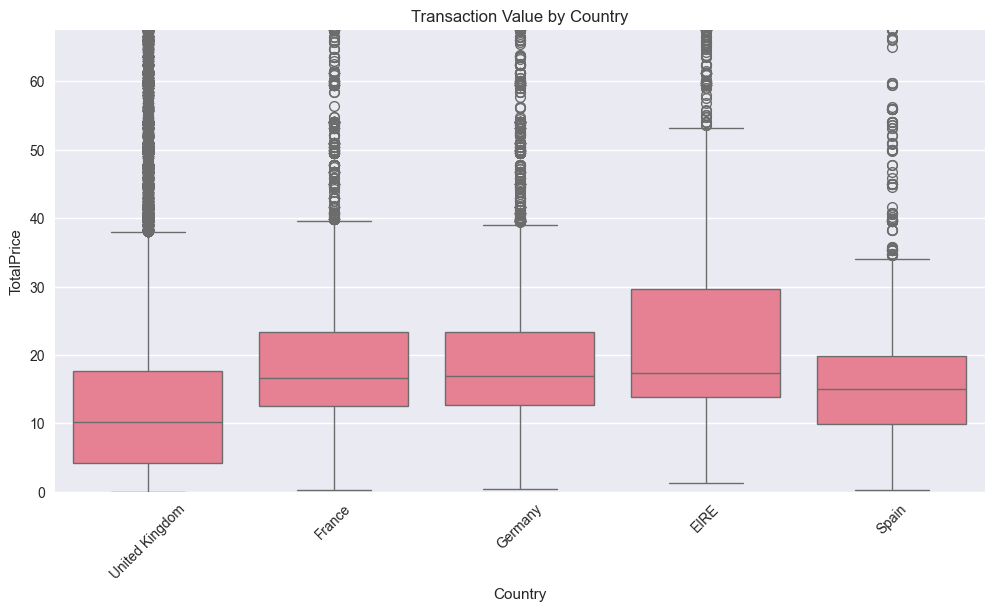

In [27]:
# 14. Monetary Value by Country (Boxplot)
plt.figure(figsize=(12,6))
top_countries = df['Country'].value_counts().head(5).index
sns.boxplot(x='Country', y='TotalPrice', 
           data=df[df['Country'].isin(top_countries)])
plt.title('Transaction Value by Country')
plt.xticks(rotation=45)
plt.ylim(0, df['TotalPrice'].quantile(0.95))
plt.show()

In [28]:
X = rfm[['Recency', 'Frequency', 'AOV', 'ProductVariety', 'PurchaseInterval']]
y = rfm['Monetary_log']  # Using log-transformed target

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [29]:
# ======================
# STEP 7: MODEL TRAINING
# ======================
# XGBoost with hyperparameter tuning
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.7,
    random_state=42
)


In [32]:
xgb_model.fit(X_train_scaled, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [33]:
# ======================
# STEP 8: MODEL EVALUATION
# ======================
# Predictions (converting back from log scale)
y_pred_log = xgb_model.predict(X_test_scaled)
y_pred = pt.inverse_transform(y_pred_log.reshape(-1, 1)).flatten()
y_test_actual = pt.inverse_transform(y_test.values.reshape(-1, 1)).flatten()



In [34]:
# Calculate metrics
metrics = {
    'MAE': mean_absolute_error(y_test_actual, y_pred),
    'RMSE': np.sqrt(mean_squared_error(y_test_actual, y_pred)),
    'R2': r2_score(y_test_actual, y_pred)
}

print("\nModel Performance:")
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")



Model Performance:
MAE: 314.1642
RMSE: 2817.4767
R2: 0.9225


<Figure size 1000x600 with 0 Axes>

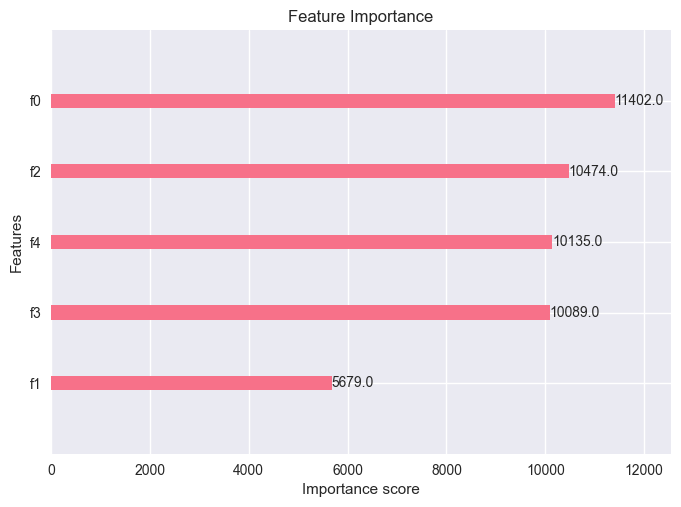

In [35]:
# Feature Importance
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model)
plt.title('Feature Importance')
plt.show()

In [41]:
# ======================
# STEP 9: SAVE OUTPUTS (FIXED)
# ======================

# First reset the index to make CustomerID a column
rfm = rfm.reset_index()

# Save model artifacts
joblib.dump(xgb_model, 'ltv_xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(pt, 'power_transformer.pkl')

['power_transformer.pkl']

In [43]:
# Save predictions with customer segments
rfm['LTV_Predicted'] = pt.inverse_transform(
    xgb_model.predict(scaler.transform(X)).reshape(-1, 1)
).flatten()

rfm['LTV_Segment'] = pd.qcut(
    rfm['LTV_Predicted'],
    q=3,
    labels=['Low', 'Medium', 'High']
)

# Final output CSV
output_cols = [
    'CustomerID', 'Recency', 'Frequency', 'Monetary',
    'AOV', 'ProductVariety', 'LTV_Predicted', 'LTV_Segment'
]
rfm[output_cols].to_csv('customer_ltv_predictions.csv', index=False)

print("\nProcess completed successfully! Outputs saved:")
print("- 15 visualizations")
print("- Trained XGBoost model (ltv_xgb_model.pkl)")
print("- Customer predictions (customer_ltv_predictions.csv)")


Process completed successfully! Outputs saved:
- 15 visualizations
- Trained XGBoost model (ltv_xgb_model.pkl)
- Customer predictions (customer_ltv_predictions.csv)
